## Project: Wrangling and Analyze Data

## Table of Contents
- <a href = "#intro"> Introduction </a>
    - <a href = "#imports"> Notebook Imports </a>
    - <a href = "#constants"> Constants </a>
    - <a href = "#functions"> Functions </a>
- Data Wrangling
    - <a href = "#gathering"> Data Gathering </a>
    - <a href = "#assessing"> Data Assessing </a>
    - <a href = "#cleaning"> Data Cleaning </a>
        - <a href = "#quality">Quality Issues</a>
        - <a href = "#tidiness">Tidiness Issues</a>
    - <a href = "#storing"> Data Storing </a>
- <a href = "#analysis"> Data Analysis and Visualization </a>
- <a href = "#conclusions"> Conclusions </a>

<a id='intro'></a>
## Introduction
> The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

<a id='imports'></a>
### Notebook Imports

In [1]:
import pandas as pd # For manipulation of dataframe

import numpy as np # For manipulation of dataframe

import os # For accessing the Operating system

import requests # for accessing web urls

import tweepy # For accessing and manipulating twitter API

import json # For mnipulating Json files

# For Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

<a id='constants'></a>
### Constants

In [2]:
file_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
image_file = file_url.split("/")[-1]

API_KEY = input("Enter API key: ")
API_SECRET = input("Enter API secret: ")
ACCESS_TOKEN = input("Enter access token: ")
ACCESS_SECRET = input("Enter access secret: ")

Enter API key: xO7mdDFyOW0Qf6FrkbjBq4oxM
Enter API secret: thxp1I69xrrgl8F2sgreX96VdXBvZubv4Yb1vRrf5y2G0bSYDu
Enter access token: 1147169775505854464-1yxEgZ0VMcEG3IXFfLpGFKTohl3fVb
Enter access secret: 68n7vfuF8QbCBMIog9CD39f3TcDaPteGu6mp7qakp1vHA


<a id = "functions"></a>
### Functions

In [3]:
def df_info(df):
    info = df.info()
    isna = df.isna().sum()
    duplicates = df.duplicated().any().sum()
    
    print(f"\n \n Duplicates = {duplicates}\n")
    return isna

In [45]:
def none_to_null(value):
    if value == 'None':
        value = np.NaN
    return value

<a id = "gathering"></a>
## Data Gathering
In the cell below, we gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [54]:
# Directly read csv file
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
# Download the file from the URl
response = requests.get(file_url)

# Specify the path for the file to be saved
with open(os.path.join(os.getcwd(), image_file), "wb") as file:
    file.write(response.content)

In [6]:
image_df = pd.read_csv(image_file, sep = "\t")
image_df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
auth = tweepy.OAuth1UserHandler(API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True)
api.verify_credentials()

User(_api=<tweepy.api.API object at 0x000001D05BA8ABE0>, _json={'id': 1147169775505854464, 'id_str': '1147169775505854464', 'name': 'HannahNS', 'screen_name': 'Nwokocha_Hannah', 'location': '', 'description': 'Javascript Enthusiast', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 95, 'friends_count': 188, 'listed_count': 0, 'created_at': 'Fri Jul 05 15:46:02 +0000 2019', 'favourites_count': 283, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 123, 'lang': None, 'status': {'created_at': 'Mon Feb 22 04:42:22 +0000 2021', 'id': 1363710700154212353, 'id_str': '1363710700154212353', 'text': "Hey, I am going to be documenting my progress on @hashnode. It's amazing and I think you should try it too.", 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'hashnode', 'name': 'Hashnode', 'id': 3957817872, 'id_str': '3957817872', 'indices': [49, 58]}], 'ur

In [8]:
# Tweet IDs for which to gather additional data via Twitter's API
archive_ids = archive_df["tweet_id"].values
print(len(archive_ids))

2356


In [10]:
%%time
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
order = 0
fails = {}

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in archive_ids:
        order += 1
        if order % 10 == 0:
            print(str(order) + ': ' + str(tweet_id))
        
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            print('success')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            
        # For failed tweet ids
        except tweepy.errors.TweepyException as e:
            print('failed')
            fails[tweet_id] = e
            pass
    
print(fails)
len(fails)

success
success
success
success
success
success
success
success
success
10: 890240255349198849
success
success
success
success
success
success
success
success
success
success
20: 888202515573088257
failed
success
success
success
success
success
success
success
success
success
30: 886366144734445568
success
success
success
success
success
success
success
success
success
success
40: 884876753390489601
success
success
success
success
success
success
success
success
success
success
50: 882762694511734784
success
success
success
success
success
success
success
success
success
success
60: 880872448815771648
success
success
success
success
success
success
success
success
success
success
70: 879050749262655488
success
success
success
success
success
success
success
success
success
success
80: 877556246731214848
success
success
success
success
success
success
success
success
success
success
90: 875021211251597312
success
success
success
success
success
success
failed
success
success
success
100

success
success
success
success
success
success
success
success
800: 772826264096874500
success
success
success
success
success
success
success
success
success
success
810: 771500966810099713
success
success
success
success
success
success
failed
success
success
failed
820: 770655142660169732
success
success
success
success
success
success
success
success
success
success
830: 768909767477751808
success
success
success
success
success
success
success
success
success
success
840: 767191397493538821
success
success
failed
success
success
success
success
success
success
success
850: 766008592277377025
success
success
success
success
success
success
success
success
success
success
860: 763183847194451968
success
success
success
success
success
success
success
success
success
success
870: 761745352076779520
success
success
success
success
success
success
success
success
success
success
880: 760641137271070720
success
success
success
success
success
success
success
success
failed
success
890:

Rate limit reached. Sleeping for: 115


success
success
success
success
success
success
success
960: 751251247299190784
success
success
success
success
success
success
success
success
success
success
970: 750132105863102464
success
success
success
success
success
success
success
success
success
success
980: 749981277374128128
success
success
success
success
success
success
success
success
success
success
990: 748932637671223296
success
success
success
success
success
success
success
success
success
success
1000: 748220828303695873
success
success
success
success
success
success
success
success
success
success
1010: 747512671126323200
success
success
success
success
success
success
success
success
success
success
1020: 746790600704425984
success
success
success
success
success
success
success
success
success
success
1030: 745712589599014916
success
success
success
success
success
success
success
success
success
success
1040: 744234799360020481
success
success
success
success
success
success
success
success
success
success
105

success
success
success
success
success
success
1740: 679511351870550016
success
success
success
success
success
success
success
success
success
success
1750: 679047485189439488
success
success
success
success
success
success
success
success
success
success
1760: 678740035362037760
success
success
success
success
success
success
success
success
success
success
1770: 678380236862578688
success
success
success
success
success
success
success
success
success
success
1780: 677716515794329600
success
success
success
success
success
success
success
success
success
success
1790: 677547928504967168
success
success
success
success
success
success
success
success
success
success
1800: 677187300187611136
success
success
success
success
success
success
success
success
success
success
1810: 676864501615042560
success
success
success
success
success
success
success
success
success
success
1820: 676590572941893632
success
success
success
success
success
success
success
success
success
success
1830: 6

Rate limit reached. Sleeping for: 124


success
success
success
success
success
success
success
1860: 675497103322386432
success
success
success
success
success
success
success
success
success
success
1870: 675153376133427200
success
success
success
success
success
success
success
success
success
success
1880: 675015141583413248
success
success
success
success
success
success
success
success
success
success
1890: 674774481756377088
success
success
success
success
success
success
success
success
success
success
1900: 674670581682434048
success
success
success
success
success
success
success
success
success
success
1910: 674422304705744896
success
success
success
success
success
success
success
success
success
success
1920: 674269164442398721
success
success
success
success
success
success
success
success
success
success
1930: 674042553264685056
success
success
success
success
success
success
success
success
success
success
1940: 673887867907739649
success
success
success
success
success
success
success
success
success
success

29

In [11]:
# creating a dictionary to hold the tweets
tweet_list = [json.loads(line) for line in open('tweet_json.txt', "r")]

In [12]:
tweet_df = []
for tweet in tweet_list:
    tweet_id = tweet['id']
    tweet_likes = tweet['favorite_count']
    tweet_retweet = tweet['retweet_count']
    
    tweet_holder = {
        'tweet_id': tweet_id,
        'tweet_likes': tweet_likes,
        'tweet_retweet': tweet_retweet
    }
    
    tweet_df.append(tweet_holder)
    
tweet_df

[{'tweet_id': 892420643555336193, 'tweet_likes': 33651, 'tweet_retweet': 6962},
 {'tweet_id': 892177421306343426, 'tweet_likes': 29197, 'tweet_retweet': 5268},
 {'tweet_id': 891815181378084864, 'tweet_likes': 21958, 'tweet_retweet': 3463},
 {'tweet_id': 891689557279858688, 'tweet_likes': 36729, 'tweet_retweet': 7182},
 {'tweet_id': 891327558926688256, 'tweet_likes': 35124, 'tweet_retweet': 7709},
 {'tweet_id': 891087950875897856, 'tweet_likes': 17717, 'tweet_retweet': 2580},
 {'tweet_id': 890971913173991426, 'tweet_likes': 10323, 'tweet_retweet': 1646},
 {'tweet_id': 890729181411237888,
  'tweet_likes': 56568,
  'tweet_retweet': 15668},
 {'tweet_id': 890609185150312448, 'tweet_likes': 24406, 'tweet_retweet': 3601},
 {'tweet_id': 890240255349198849, 'tweet_likes': 27832, 'tweet_retweet': 6063},
 {'tweet_id': 890006608113172480, 'tweet_likes': 26911, 'tweet_retweet': 6110},
 {'tweet_id': 889880896479866881, 'tweet_likes': 24454, 'tweet_retweet': 4138},
 {'tweet_id': 889665388333682689, '

In [13]:
tweet_df = pd.DataFrame(tweet_df)

<a id='assessing'></a>
## Assessing Data

In [14]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [15]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
archive_df[archive_df['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [17]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2208,668625577880875008,NaN,NaN,2015-11-23 03:02:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maks. Maks just noticed something wasn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668625577...,10,10,Maks,None,None,None,None
823,770069151037685760,NaN,NaN,2016-08-29 01:22:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Carbon. This is his first time sw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770069151...,10,10,Carbon,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
2234,668190681446379520,NaN,NaN,2015-11-21 22:14:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Skittles. I would kidnap Skittles. Pin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668190681...,12,10,Skittles,None,None,None,None
991,748699167502000129,NaN,NaN,2016-07-01 02:06:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Tripp. He's being eaten by a sherk and do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748699167...,11,10,Tripp,None,None,None,None


In [19]:
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [20]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [22]:
image_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
257,670778058496974848,https://pbs.twimg.com/media/CU8VFhuVAAAQW8B.jpg,1,pug,0.776612,True,Brabancon_griffon,0.112032,True,boxer,0.039051,True
1893,849412302885593088,https://pbs.twimg.com/media/C8m3-iQVoAAETnF.jpg,4,schipperke,0.907559,True,crossword_puzzle,0.017934,False,Chihuahua,0.016191,True
1660,811627233043480576,https://pbs.twimg.com/media/C0N6opSXAAAkCtN.jpg,1,beagle,0.396280,True,Pembroke,0.049562,True,wire-haired_fox_terrier,0.046349,True
1868,844223788422217728,https://pbs.twimg.com/media/C7dJCnqU4AAswat.jpg,1,Labrador_retriever,0.719510,True,Chesapeake_Bay_retriever,0.122019,True,Newfoundland,0.038828,True
204,669753178989142016,https://pbs.twimg.com/media/CUtw9SAVEAAtFUN.jpg,1,Pembroke,0.858494,True,hamster,0.026319,False,Shetland_sheepdog,0.022405,True


In [23]:
tweet_df

,tweet_id,tweet_likes,tweet_retweet
0,892420643555336193,33651,6962
1,892177421306343426,29197,5268
2,891815181378084864,21958,3463
3,891689557279858688,36729,7182
4,891327558926688256,35124,7709
...,...,...,...
2322,666049248165822465,88,36
2323,666044226329800704,245,114
2324,666033412701032449,100,36
2325,666029285002620928,112,39


In [24]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   tweet_id       2327 non-null   int64
 1   tweet_likes    2327 non-null   int64
 2   tweet_retweet  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [25]:
tweet_df.describe()

,tweet_id,tweet_likes,tweet_retweet
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,7019.501504,2456.835410
std,6.820795e+16,10907.175188,4160.015012
min,6.660209e+17,0.000000,1.000000
25%,6.781394e+17,1218.500000,492.500000
50%,7.178418e+17,3032.000000,1143.000000
75%,7.986547e+17,8555.000000,2843.500000
max,8.924206e+17,144035.000000,70257.000000


In [26]:
tweet_df.sample(5)

,tweet_id,tweet_likes,tweet_retweet
1145,720340705894408192,2620,872
1326,703631701117943808,2355,599
1945,673148804208660480,1485,547
2040,671134062904504320,652,162
764,774757898236878852,8100,1648


In [27]:
all_columns = pd.Series(list(archive_df) + list(image_df) + list(tweet_df))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [28]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### Quality issues
<b><i>`archive` table</i></b>

1. Erroneous datatypes(tweet_id, timestamp, retweeted_status_timestamp).

2. Dropping unnecessary columns(in_reply_to_status_id, in_reply_to_user_id, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_url).

3. Capitalize all the names(name).

4. Remove retweets since they are not needed.

5. Change 'None' to NaN(name, doggo, pupper, puppo).


<b><i>`image` table</i></b>

6. Rename column names

7. Dropping unnecessary column(image_number).

8. Erroneous datatypes(tweet_id)


<b><i>`tweet` table</i></b>

9. Erroneous datatypes(tweet_id)

### Tidiness issues
1. One variable spans Four columns in `archive` table

2. Combine the three tables(dog type, likes and retweet should be part of the `archive` table)

<a id='cleaning'></a>
## Cleaning Data

In [55]:
# Make copies of original pieces of data
archive_clean = archive_df.copy()
image_clean = image_df.copy()
tweet_clean = tweet_df.copy()

<a id='quality'></a>
## QUALITY ISSUES

### `ARCHIVE` DATAFRAME
### Removing Retweets

#### Define:
We have to drop rows that are replies or retweets since thay are not needed as part of the dataset

#### Code

In [56]:
# find row that are replies
replies = (~archive_clean.in_reply_to_status_id.isnull())
replies.sum()

archive_clean = archive_clean[~replies]

In [57]:
# find row that are retweets
retweet = (~archive_clean.retweeted_status_id.isnull())
retweet.sum()

archive_clean = archive_clean[~retweet]

#### Test

In [58]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

### Dropping unnecessary columns

#### Define
Dropping unnecessary columns(in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_url)

#### Code

In [60]:
archive_clean.drop(["in_reply_to_status_id", 
                    "in_reply_to_user_id",
                    "source", "text",
                    "retweeted_status_id", 
                    "retweeted_status_user_id", 
                    "retweeted_status_timestamp",
                   "expanded_urls"], axis = 1, inplace = True)

#### Test

In [61]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   rating_numerator    2097 non-null   int64 
 3   rating_denominator  2097 non-null   int64 
 4   name                2097 non-null   object
 5   doggo               2097 non-null   object
 6   floofer             2097 non-null   object
 7   pupper              2097 non-null   object
 8   puppo               2097 non-null   object
dtypes: int64(3), object(6)
memory usage: 163.8+ KB


### Erroneous Datatype

#### Define:
Erroneous datatypes(tweet_id, timestamp, retweeted_status_timestamp) but since the retweeted_status_timestamp column has already been dropped we would just change the datatype of:
<ul>
    <li>timestamp from object to datetime</li>
    <li>tweet_id from int to object</li>
</ul>

#### Code

In [43]:
archive_clean = archive_clean.astype({
    "tweet_id": object
})
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

#### Test

In [44]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   rating_numerator    2097 non-null   int64              
 5   rating_denominator  2097 non-null   int64              
 6   name                2097 non-null   object             
 7   doggo               2097 non-null   object             
 8   floofer             2097 non-null   object             
 9   pupper              2097 non-null   object             
 10  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(8)
memory usage: 196.6+ KB


### Capitalize names

#### Define:
Names are meant to be capitalized, so we just capitalize all the values in the name column

#### Code

In [63]:
archive_clean["name"] = [name.capitalize() for name in archive_clean["name"]]

#### Test

In [50]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1771,678334497360859136,2015-12-19 22:02:01+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Rosie. She has a snazzy bow tie and a ...,10,10,Rosie,NaN,NaN,NaN,NaN
1463,694669722378485760,2016-02-02 23:52:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phil. He's an important dog. Can contr...,12,10,Phil,NaN,NaN,NaN,NaN
401,824663926340194305,2017-01-26 17:02:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Wilson. Named after the volleyball. He...,13,10,Wilson,NaN,NaN,NaN,NaN
2280,667393430834667520,2015-11-19 17:26:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Fwed. He is a Canadian Asian Taylormad...,8,10,Fwed,NaN,NaN,NaN,NaN
1685,681654059175129088,2015-12-29 01:52:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Toffee. He's a happy pupper. Appears d...,12,10,Toffee,NaN,NaN,pupper,NaN


### Change 'None' to NaN

#### Define:
Change 'None' to NaN(name, doggo, pupper, puppo)

#### Code

In [78]:
archive_clean["name"] = [none_to_null(value) for value in archive_clean["name"]]

archive_clean["doggo"] = [none_to_null(value) for value in archive_clean["doggo"]]
archive_clean["floofer"] = [none_to_null(value) for value in archive_clean["floofer"]]
archive_clean["pupper"] = [none_to_null(value) for value in archive_clean["pupper"]]
archive_clean["puppo"] = [none_to_null(value) for value in archive_clean["puppo"]]

#### Test

In [79]:
archive_clean.sample(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
823,770069151037685760,2016-08-29 01:22:47 +0000,10,10,Carbon,NaN,NaN,NaN,NaN
143,864197398364647424,2017-05-15 19:14:50 +0000,13,10,Paisley,NaN,NaN,NaN,NaN
672,789903600034189313,2016-10-22 18:57:48 +0000,13,10,Ralphy,NaN,NaN,pupper,NaN
2146,669923323644657664,2015-11-26 16:59:01 +0000,10,10,a,NaN,NaN,NaN,NaN
1611,685325112850124800,2016-01-08 05:00:14 +0000,10,10,NaN,NaN,NaN,NaN,NaN


### `IMAGE` Table

### Rename column names

#### Define:
Rename column names of the image table since the column names are not descriptive enough

#### Code

In [65]:
image_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [68]:
image_clean.rename({
    'tweet_id': 'tweet_id',
    'jpg_url': 'image_url',
    'img_num': 'image_number',
    'p1': 'prediction1',
    'p1_conf': 'prediction_confidence1',
    'p1_dog': 'predicted_dog1',
    'p2': 'prediction2',
    'p2_conf': 'prediction_confidence2',
    'p2_dog': 'predicted_dog2',
    'p3': 'prediction3',
    'p3_conf': 'prediction_confidence3',
    'p3_dog': 'predicted_dog3'
}, axis = 1, inplace = True)

#### Test

In [69]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   image_url               2075 non-null   object 
 2   image_number            2075 non-null   int64  
 3   prediction1             2075 non-null   object 
 4   prediction_confidence1  2075 non-null   float64
 5   predicted_dog1          2075 non-null   bool   
 6   prediction2             2075 non-null   object 
 7   prediction_confidence2  2075 non-null   float64
 8   predicted_dog2          2075 non-null   bool   
 9   prediction3             2075 non-null   object 
 10  prediction_confidence3  2075 non-null   float64
 11  predicted_dog3          2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Dropping unnecessary column

#### Define:
Dropping the image number column

#### Code

In [71]:
image_clean.drop(["image_number"], axis = 1, inplace = True)

#### Test

In [72]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   image_url               2075 non-null   object 
 2   prediction1             2075 non-null   object 
 3   prediction_confidence1  2075 non-null   float64
 4   predicted_dog1          2075 non-null   bool   
 5   prediction2             2075 non-null   object 
 6   prediction_confidence2  2075 non-null   float64
 7   predicted_dog2          2075 non-null   bool   
 8   prediction3             2075 non-null   object 
 9   prediction_confidence3  2075 non-null   float64
 10  predicted_dog3          2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.9+ KB


### Erroneous datatypes

#### Define:
Erroneous datatypes(tweet_id). Tweet_id should have a datatype of string not int

#### Code

In [73]:
image_clean = image_clean.astype({
    "tweet_id": object
})

#### Test

In [74]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   object 
 1   image_url               2075 non-null   object 
 2   prediction1             2075 non-null   object 
 3   prediction_confidence1  2075 non-null   float64
 4   predicted_dog1          2075 non-null   bool   
 5   prediction2             2075 non-null   object 
 6   prediction_confidence2  2075 non-null   float64
 7   predicted_dog2          2075 non-null   bool   
 8   prediction3             2075 non-null   object 
 9   prediction_confidence3  2075 non-null   float64
 10  predicted_dog3          2075 non-null   bool   
dtypes: bool(3), float64(3), object(5)
memory usage: 135.9+ KB


### `TWEET` TABLE

### Erroneous Datatype

#### Define:
Erroneous datatype in the tweet_id column, the datatype should be string not int

#### Code

In [75]:
tweet_clean = tweet_clean.astype({
    "tweet_id": object
})

#### Test

In [76]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       2327 non-null   object
 1   tweet_likes    2327 non-null   int64 
 2   tweet_retweet  2327 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


<a id='tidiness'></a>
## TIDINESS ISSUES

### One variable spans Three columns

#### Define:
One variable spans Three columns in `archive` table, so we ave to consolidate the three columns to a new clumn called dog_state where we would have the states that were given and the empty space would would filled with NaN

#### Code

In [80]:
# form the dog_state column from the three columns
archive_clean['dog_state'] = archive_clean.doggo.fillna(archive_clean.floofer.fillna(archive_clean.pupper.fillna(archive_clean.puppo)))

In [82]:
# Drop the unnecessary columns
archive_clean.drop(["doggo",
                 "floofer",
                 "pupper",
                 "puppo"], axis = 1, inplace = True)

#### Test

In [85]:
archive_clean.sample(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,name,dog_state
2197,668826086256599040,2015-11-23 16:18:59 +0000,10,10,Banditt,NaN
378,827933404142436356,2017-02-04 17:34:40 +0000,12,10,Kona,pupper
961,751132876104687617,2016-07-07 19:16:47 +0000,10,10,Cooper,puppo
2161,669564461267722241,2015-11-25 17:13:02 +0000,10,10,a,NaN
805,772114945936949249,2016-09-03 16:52:02 +0000,10,10,Finn,NaN


### Combine the three tables

#### Define:
We will create a new table from merging the three tables to get one consolidated table with all information about the tweets

#### Code

In [86]:
rate_dogs_tweet = archive_clean.merge(tweet_clean, on = "tweet_id")

In [87]:
rate_dogs_tweet = rate_dogs_tweet.merge(image_clean, on = "tweet_id")

#### Test

In [88]:
rate_dogs_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                1963 non-null   object 
 1   timestamp               1963 non-null   object 
 2   rating_numerator        1963 non-null   int64  
 3   rating_denominator      1963 non-null   int64  
 4   name                    1440 non-null   object 
 5   dog_state               302 non-null    object 
 6   tweet_likes             1963 non-null   int64  
 7   tweet_retweet           1963 non-null   int64  
 8   image_url               1963 non-null   object 
 9   prediction1             1963 non-null   object 
 10  prediction_confidence1  1963 non-null   float64
 11  predicted_dog1          1963 non-null   bool   
 12  prediction2             1963 non-null   object 
 13  prediction_confidence2  1963 non-null   float64
 14  predicted_dog2          1963 non-null   

In [89]:
rate_dogs_tweet.sample(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,name,dog_state,tweet_likes,tweet_retweet,image_url,prediction1,prediction_confidence1,predicted_dog1,prediction2,prediction_confidence2,predicted_dog2,prediction3,prediction_confidence3,predicted_dog3
1233,687460506001633280,2016-01-14 02:25:31 +0000,10,10,Kramer,NaN,1904,490,https://pbs.twimg.com/media/CYpZrtDWwAE8Kpw.jpg,Boston_bull,0.223366,True,boxer,0.183596,True,French_bulldog,0.176916,True
1390,678798276842360832,2015-12-21 04:44:55 +0000,7,10,Linda,NaN,3151,1022,https://pbs.twimg.com/media/CWuTbAKUsAAvZHh.jpg,Airedale,0.583122,True,silky_terrier,0.129567,True,Lakeland_terrier,0.094727,True
527,780858289093574656,2016-09-27 19:54:58 +0000,10,10,Dash,NaN,6773,1853,https://pbs.twimg.com/media/CtYqeNHWgAATqYZ.jpg,Chesapeake_Bay_retriever,0.488555,True,Sussex_spaniel,0.271655,True,kelpie,0.106913,True
686,752660715232722944,2016-07-12 00:27:52 +0000,10,10,NaN,doggo,4062,1417,https://pbs.twimg.com/media/CnH87L6XYAAF7I_.jpg,goose,0.339324,False,English_setter,0.050512,True,basset,0.049093,True
518,782722598790725632,2016-10-02 23:23:04 +0000,10,10,Penny,NaN,16216,4983,https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg,Irish_setter,0.574557,True,golden_retriever,0.339251,True,seat_belt,0.046108,False


<a id='storing'></a>
## Storing Data

In [90]:
rate_dogs_tweet.to_csv("twitter-master-archive.csv", index = False)

<a id='analysis'></a>
## Analyzing and Visualizing Data

### Insights:
1. The most retweeted dog type

2. The Highest rated dog type

3. The most popular dog type

### The most retweeted dog type

In [101]:
sort_retweeted = rate_dogs_tweet.sort_values("tweet_retweet", ascending = False)
high_retweeted = sort_retweeted.head(1)
high_retweeted.prediction1

762    Labrador_retriever
Name: prediction1, dtype: object

The most retweeted tweet was of a Labrador retriever

### The Highest rated dog type

In [108]:
sort_rated = rate_dogs_tweet.sort_values("rating_numerator", ascending = False)
high_rated = sort_rated[sort_rated.predicted_dog1 == True]
high_rated.prediction1

golden_retriever      137
Labrador_retriever     91
Pembroke               88
Chihuahua              78
pug                    54
                     ... 
clumber                 1
groenendael             1
standard_schnauzer      1
Scotch_terrier          1
Japanese_spaniel        1
Name: prediction1, Length: 111, dtype: int64

The top rated dog was a Labrador retriever

### The most popular dog type

In [111]:
high_rated = rate_dogs_tweet[rate_dogs_tweet.predicted_dog1 == True]
high_rated.prediction1.value_counts().head(1)

golden_retriever    137
Name: prediction1, dtype: int64

The most popular dog type that was tweeted was the golden retriever

### Visualization

1. The most retweeted dog state
2. The most popular dog names

### The most retweeted dog states

In [93]:
sort_retweeted = rate_dogs_tweet.sort_values("tweet_retweet", ascending = False)
high_retweeted = sort_retweeted.head(10)
high_retweeted

,tweet_id,timestamp,rating_numerator,rating_denominator,name,dog_state,tweet_likes,tweet_retweet,image_url,prediction1,prediction_confidence1,predicted_dog1,prediction2,prediction_confidence2,predicted_dog2,prediction3,prediction_confidence3,predicted_dog3
762,744234799360020481,2016-06-18 18:26:18 +0000,13,10,NaN,doggo,144035,70257,https://pbs.twimg.com/ext_tw_video_thumb/74423...,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
797,739238157791694849,2016-06-04 23:31:25 +0000,13,10,NaN,doggo,106704,52577,https://pbs.twimg.com/ext_tw_video_thumb/73923...,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True
393,807106840509214720,2016-12-09 06:17:20 +0000,13,10,Stephan,NaN,111097,51365,https://pbs.twimg.com/ext_tw_video_thumb/80710...,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
302,822872901745569793,2017-01-21 18:26:02 +0000,13,10,NaN,puppo,123458,39713,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
58,879415818425184262,2017-06-26 19:07:24 +0000,13,10,Duddles,NaN,92359,37187,https://pbs.twimg.com/ext_tw_video_thumb/87941...,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True
326,819004803107983360,2017-01-11 02:15:36 +0000,14,10,Bo,doggo,82267,34385,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True
395,806629075125202948,2016-12-07 22:38:52 +0000,13,10,NaN,NaN,70236,32190,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
107,866450705531457537,2017-05-22 00:28:40 +0000,13,10,Jamesy,pupper,108422,30032,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,French_bulldog,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True
1401,678399652199309312,2015-12-20 02:20:55 +0000,12,10,NaN,NaN,73091,28445,https://pbs.twimg.com/ext_tw_video_thumb/67839...,swing,0.929196,False,Bedlington_terrier,0.015047,True,Great_Pyrenees,0.014039,True
1459,676219687039057920,2015-12-14 01:58:31 +0000,10,10,Kenneth,NaN,70621,27624,https://pbs.twimg.com/media/CWJqN9iWwAAg86R.jpg,bubble,0.997556,False,leafhopper,0.000159,False,whippet,0.000132,True


In [94]:
top_state = high_retweeted.dog_state.value_counts()
top_state

doggo     3
puppo     1
pupper    1
Name: dog_state, dtype: int64

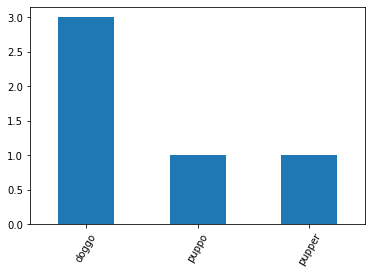

In [95]:
top_state.plot(kind='bar')
plt.xticks(rotation=60)
plt.show()

The most common dog stage that was retweeted was the Doggo stage

### The most popular dog names

In [96]:
top_names = rate_dogs_tweet.name.value_counts().nlargest(13)
top_names

a          55
Cooper     10
Charlie    10
Oliver     10
Penny       9
Lucy        9
Tucker      9
Winston     8
Sadie       8
the         7
Lola        7
Toby        7
Daisy       7
Name: name, dtype: int64

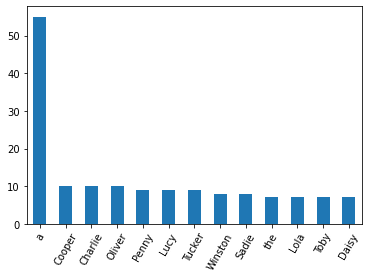

In [97]:
top_names.plot(kind='bar')
plt.xticks(rotation=60)
plt.show()

If we remove the articles 'a' and 'the', Cooper, Charlie and Oliver were the most popular names

<a id='conclusions'></a>
## Conclusions
From the analysis we were able to see that:
- Cooper, Charlie and Oliver are the most popular dog names
- Labrador retriever was the most retweeted dog type
- Doggo was the most retweeted dog state
- Golden retriever was the most popular dog type
- Labrador retriever was the highest rated dog